In [1]:
import spotpy
import numpy as np
import pandas as pd
import subprocess
import shutil
import os
from pymail import alert

In [2]:
def parse_dates(df):
    return '%s-%s-%s'%(int(df.year),int(df.month),int(df.day))

In [3]:
obspath = '/projects/RHESSys/data/niwot_new.pcl'
tmp = pd.read_pickle(obspath)

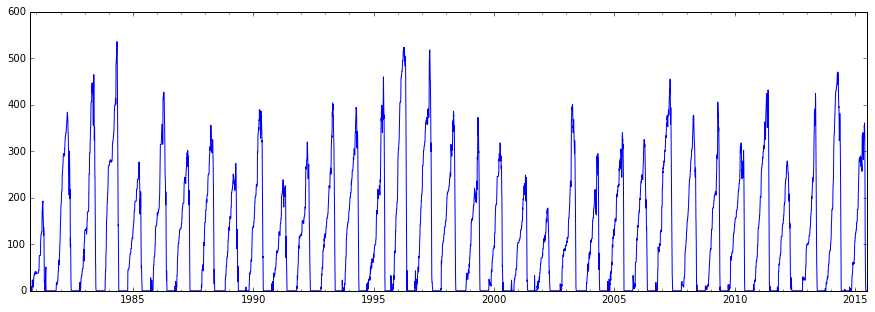

In [4]:
tmp.SWE.plot(figsize=(15,5))

In [5]:
class spotpy_setup():
    # the __init__ runs just once at the begining of the optimization
    def __init__(self):
    # define the run number
        self.num = '1'
        # define the parameters for the model
        self.params = [spotpy.parameter.Uniform('smtc',0.000001,0.6),
        spotpy.parameter.Uniform('msed',-500,0),
        spotpy.parameter.Uniform('raintemp',-4.,2.),
        spotpy.parameter.Uniform('snowtemp',-2,4.0)]

        self.obspath = obspath
        self.outpath = '/RHESSys/Como/out/opt'
        
        self.start_date = pd.datetime(1990,10,1) # simulation spinup start (RHESSys format)
        self.end_date = pd.datetime(2012,10,5) # simulation end date (RHESSys format)
        self.a_start_date = '1991-10-1' # analysis start date, pandas format
        self.a_end_date = '2012-09-30' # analysis end date, pandas format
        
        # read in the observations
        obs = pd.read_pickle(self.obspath)[self.a_start_date:self.a_end_date]
        self.obs = obs.SWE.as_matrix() # pull out the observations
        
        self.ct = 0 # counter
        
        self.evaldates = obs.index
        
    def parameters(self):
        # generate the parameters
        return spotpy.parameter.generate(self.params)


    def simulation(self,vector):
        
        smtc = vector[0]
        msed = vector[1]
        raintemp = vector[2]
        snowtemp = vector[3]
        
        strtyear = self.start_date.year
        strtmonth = self.start_date.month
        strtday = self.start_date.day
        endyear = self.end_date.year
        endmonth = self.end_date.month
        endday = self.end_date.day
        
        #create the output directory
        idx = self.ct
        
        # run the simulation using the rhessys script
        cmd = 'sh /RHESSys/Como/scripts/rhessys_opt_ullr_grid_snow.sh %s %s %s %s %s %s %s %s %s %s %s'%(smtc,
        msed, raintemp, snowtemp,strtyear,strtmonth,strtday,endyear,endmonth,endday,int(idx))
        
        #print cmd
        
        subprocess.call(cmd,shell=True)
        
        # load the output
        sim = pd.read_table('/RHESSys/Como/out/opt/%s_basin.daily'%(idx),sep = ' ')
        sim['datetime'] = sim.apply(parse_dates,axis=1)
        sim.index = pd.DatetimeIndex(sim.datetime)
        sim = sim[self.a_start_date:self.a_end_date]
        
        # delete the output
        cmd = 'rm /RHESSys/Como/out/opt/%s_*'%(idx)
        subprocess.call(cmd,shell=True)
        
        self.ct += 1 # increment counter
        return sim.snowpack.as_matrix()


    def evaluation(self,evaldates=False):
        # function to return the evaluation data
        if evaldates==True:
            return self.evaldates
        
        if evaldates==False:
            return self.obs


    def objectivefunction(self,simulation,evaluation):
        # compute the objective function
        objectivefunction = spotpy.objectivefunctions.nashsutcliff(evaluation,simulation) # we want to maximize this function
        return objectivefunction

## Notes:

- snow1opt is done with unscaled precipitation - NSE: 0.92
- snow2opt is done with scaled precip to match Knowles 2014 - NSE: 0.62
- A third option would be to split the difference change the distribution scheme to make the Niwot Snotel grid cell have a weight of 1 - this would be snow3opt

- for now, going with the parameters from snow2opt for the hydrologic model calibration.

In [6]:
spotpy_setup = spotpy_setup()

sampler = spotpy.algorithms.sceua(spotpy_setup,dbname='snow3opt',dbformat='csv')

In [7]:
sampler.sample(15000, ngs=5, kstop = 100, pcento=0.25, peps=0.25)

2 of 15000 (best like=-79.1349)
5 of 15000 (best like=-79.1349)
8 of 15000 (best like=-79.1349)
11 of 15000 (best like=-79.1349)
14 of 15000 (best like=-79.1349)
17 of 15000 (best like=-79.1349)
20 of 15000 (best like=-79.1349)
23 of 15000 (best like=-79.1349)
26 of 15000 (best like=-79.1349)
29 of 15000 (best like=-79.1349)
32 of 15000 (best like=-79.1349)
35 of 15000 (best like=-79.1349)
38 of 15000 (best like=-79.1349)
41 of 15000 (best like=-79.1349)
44 of 15000 (best like=-79.1349)
90 of 15000 (best like=-78.574)
135 of 15000 (best like=-78.574)
180 of 15000 (best like=-78.4974)
225 of 15000 (best like=-78.245)
270 of 15000 (best like=-78.0879)
315 of 15000 (best like=-77.9854)
360 of 15000 (best like=-77.9854)
405 of 15000 (best like=-77.8861)
450 of 15000 (best like=-77.8861)
495 of 15000 (best like=-77.8861)
540 of 15000 (best like=-77.8861)
585 of 15000 (best like=-77.8861)
630 of 15000 (best like=-77.8861)
675 of 15000 (best like=-77.8861)
720 of 15000 (best like=-77.8861)
76

In [8]:
results = sampler.getdata()

In [9]:
tmp = pd.DataFrame(results)

In [10]:
tmp.sort_values(by='like1',ascending=False,inplace=True)

In [11]:
tmp.head()

,like1,parsmtc,parmsed,parraintemp,parsnowtemp,simulation1,simulation2,simulation3,simulation4,simulation5,...,simulation7663,simulation7664,simulation7665,simulation7666,simulation7667,simulation7668,simulation7669,simulation7670,simulation7671,chain
2958,-77.816108,0.492078,-144.402523,1.998388,3.995906,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2913,-77.816733,0.443155,-144.498416,1.998592,3.994564,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2881,-77.817083,0.497886,-144.297936,1.998109,3.994431,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2993,-77.817322,0.507134,-144.435915,1.998112,3.993996,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2933,-77.817592,0.453618,-144.516040,1.998151,3.993468,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
sims = tmp.ix[tmp.like1>-78.]

In [29]:
sims.shape

(293, 7677)

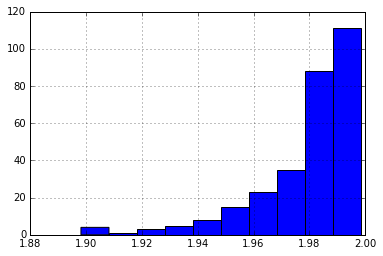

In [30]:
sims.parraintemp.hist()

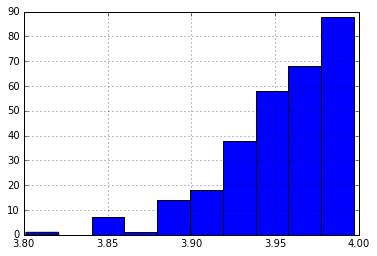

In [31]:
sims.parsnowtemp.hist()

In [32]:
sims.loc[sims.parsnowtemp==sims.parsnowtemp.min()]

,like1,parsmtc,parmsed,parraintemp,parsnowtemp,simulation1,simulation2,simulation3,simulation4,simulation5,...,simulation7663,simulation7664,simulation7665,simulation7666,simulation7667,simulation7668,simulation7669,simulation7670,simulation7671,chain
2790,-77.975291,0.444683,-145.123052,1.969845,3.801154,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Using the above parameters

In [40]:
sim = sims.ix[sims.parsnowtemp==sims.parsnowtemp.min(),5:-1].as_matrix()[0]

In [41]:
sim

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

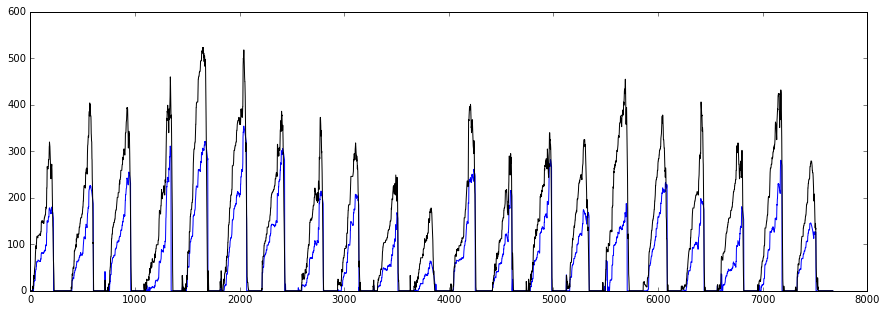

In [42]:
plt.figure(figsize=(15,5))
plt.plot(sim,'b',label='simulation')
#for i in xrange(len(sims)):
#    plt.plot(sims[i,:],'0.5',label='simulation')
#    
plt.plot(spotpy_setup.obs,'k',label='observations')

In [43]:
from hydro import objective_fxns as obfx

In [44]:
obfx.nashsut(spotpy_setup.obs,sim)

0.62679112625449485

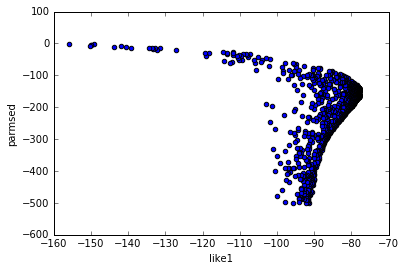

In [21]:
tmp.plot.scatter('like1','parmsed')

## Scratch

In [23]:
sampler.evaluation

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [26]:
sampler.objectivefunction(sampler.evaluation,sim)/100.

0.53044912445844605

In [20]:
 = pd.read_table('/RHESSys/Como/out/opt/0_basin.daily',sep=' ')
tmp['datetime'] = tmp.apply(parse_dates,axis=1)
tmp.index = pd.DatetimeIndex(tmp.datetime)
tmp = tmp[spotpy_setup.a_start_date:spotpy_setup.a_end_date]

In [21]:
tmp.shape

(7671, 74)

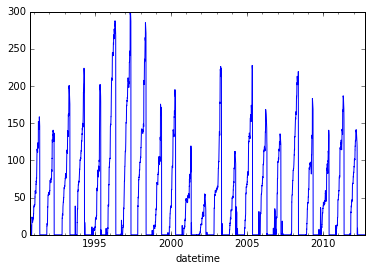

In [19]:
tmp.snowpack.plot()

In [57]:
spotpy_setup.a_start_date

'1991-10-1'